In [1]:
import pandas as pd
import numpy as np
import missingno as mo

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule
from sklearn.linear_model import LogisticRegression as Logit

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#plotting
from plotnine import *
import matplotlib.pyplot as plt

# permutation
from sklearn.inspection import permutation_importance

In [2]:
jordan = pd.read_csv("arabbaro/arabbaro_jo_labeled_reduced.csv")

In [3]:
jordan.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

In [4]:
kuwait = pd.read_csv("arabbaro/arabbaro_kuw_labeled_reduced.csv")

In [5]:
kuwait.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [6]:
egypt = pd.read_csv("arabbaro/arabbaro_egy_labeled_reduced.csv")

In [7]:
egypt.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [8]:
morocco = pd.read_csv("arabbaro/arabbaro_mor_labeled_reduced.csv")

In [9]:
morocco.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"], inplace = True)

In [10]:
algeria = pd.read_csv("arabbaro/arabbaro_alg_labeled_reduced.csv")

In [11]:
algeria.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"],inplace = True)

In [12]:
def dempref(df):
    # set up SKLearn Framework
    y = df.y_2_dem_pref_not_in_dem
    if 'y_1_trust_gov' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
    else:  
        X = df.drop(columns = "y_2_dem_pref_not_in_dem")

    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=4)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

In [13]:
def trustgov(df):
    # set up SKLearn Framework
    y = df.y_1_trust_gov
    if 'y_2_dem_pref_not_in_dem' in df.columns:
        X = df.drop(columns = ["y_2_dem_pref_not_in_dem", "y_1_trust_gov"])
    else:  
        X = df.drop(columns = "y_1_trust_gov")
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
        
        # logit model
        {'model': [Logit()],
        'model__class_weight':[None, "balanced"]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=4)

    # fit the data with the model
    search.fit(train_X,train_y)
    
    best_mod = search.best_estimator_

    return(search.best_score_, search.best_estimator_, search.predict(test_X), m.plot_confusion_matrix(best_mod, test_X, test_y), train_X, test_X, train_y, test_y)

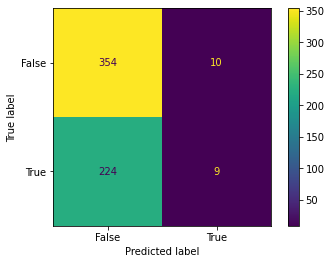

In [14]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(jordan)

In [15]:
score

0.5588070946540447

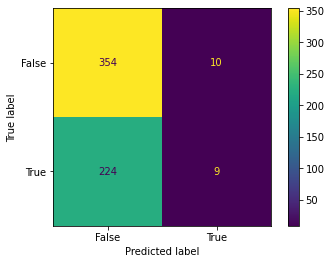

In [16]:
confusion.figure_

In [17]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=10,
                                        n_estimators=1000))])

In [18]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [19]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.022557,0.002882,0.016794,0.028321
1,educ,0.011390,0.001679,0.008033,0.014748
2,internet_use_ordinal_4_is_top,0.009604,0.001555,0.006493,0.012714
3,internet_use_bin,0.009492,0.001368,0.006757,0.012227
4,male,0.008487,0.001139,0.006209,0.010764
5,neighb_rich,0.007594,0.002165,0.003263,0.011924
6,infs_socmed,0.007370,0.001083,0.005205,0.009536
7,infs_television,0.005137,0.000821,0.003496,0.006778
8,retired,0.004802,0.000907,0.002987,0.006616
9,orgmem,0.004467,0.000865,0.002737,0.006197


In [20]:
vi_dat.to_csv("variable importance csv/jordan_y2")

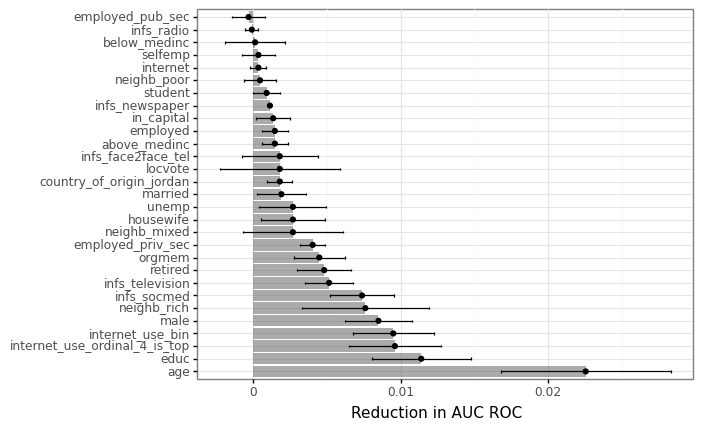

<ggplot: (8789835819770)>

In [21]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

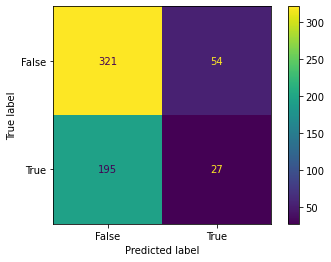

In [22]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(jordan)

In [23]:
score

0.5860997063624547

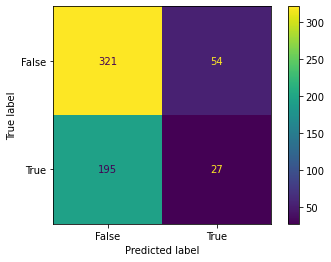

In [24]:
confusion.figure_

In [25]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', LogisticRegression())])

In [26]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [27]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,above_medinc,0.013177,0.004964,0.003249,0.023105
1,educ,0.010609,0.006463,-0.002318,0.023535
2,internet,0.009492,0.003038,0.003416,0.015567
3,retired,0.006700,0.003099,0.000503,0.012898
4,selfemp,0.004690,0.001203,0.002285,0.007096
5,neighb_mixed,0.004132,0.003542,-0.002952,0.011216
6,housewife,0.003573,0.003780,-0.003987,0.011134
7,neighb_rich,0.002903,0.001848,-0.000794,0.006600
8,internet_use_bin,0.002792,0.004042,-0.005292,0.010875
9,internet_use_ordinal_4_is_top,0.002792,0.004042,-0.005292,0.010875


In [28]:
vi_dat.to_csv("variable importance csv/jordan_y1")

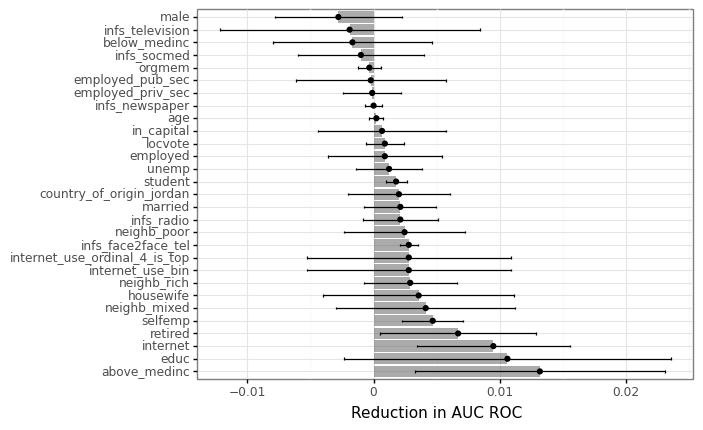

<ggplot: (8789835874681)>

In [29]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [30]:
kuwait.isna().sum()

below_medinc             0
above_medinc             0
in_capital               0
married                  0
employed                 0
employed_pub_sec         0
employed_priv_sec        0
selfemp                  0
retired                  0
housewife                0
student                  0
unemp                    0
neighb_rich           1364
neighb_poor           1364
neighb_mixed          1364
educ                     0
male                     0
age                      0
orgmem                   0
locvote                  0
internet                 0
internet_use_bin         0
infs_face2face_tel       0
infs_newspaper           0
infs_radio               0
infs_television          0
infs_socmed              0
y_1_trust_gov            0
dtype: int64

In [31]:
kuwait.drop(columns = ["neighb_rich", "neighb_poor", "neighb_mixed"], inplace = True)

In [32]:
kuwait

,below_medinc,above_medinc,in_capital,married,employed,employed_pub_sec,employed_priv_sec,selfemp,retired,housewife,...,orgmem,locvote,internet,internet_use_bin,infs_face2face_tel,infs_newspaper,infs_radio,infs_television,infs_socmed,y_1_trust_gov
0,False,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
1,False,True,False,True,True,True,False,False,False,False,...,True,True,True,1.0,False,False,False,False,True,True
2,False,False,False,True,False,False,False,False,True,False,...,False,False,True,0.8,False,False,False,False,True,False
3,True,False,False,True,False,False,False,False,True,False,...,False,True,True,1.0,False,False,False,False,True,False
4,True,False,False,True,True,True,False,False,False,False,...,False,False,True,1.0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,False,True,False,True,False,False,False,False,True,False,...,False,True,True,0.8,False,False,False,False,True,True
1360,False,False,False,False,False,False,False,False,False,False,...,True,False,True,1.0,False,False,False,False,True,True
1361,False,False,False,True,True,True,False,False,False,False,...,False,True,True,1.0,False,False,False,False,True,False
1362,False,False,False,True,True,True,False,False,False,False,...,True,True,True,1.0,False,False,False,False,True,False


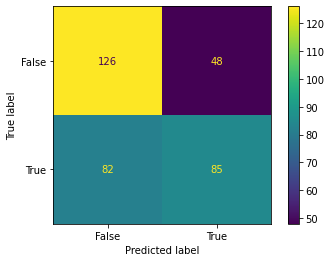

In [33]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(kuwait)

In [34]:
score

0.6542622451778654

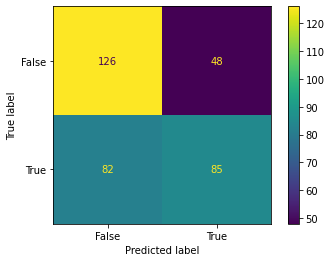

In [35]:
confusion.figure_

In [36]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=500))])

In [37]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [38]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,infs_socmed,0.079374,0.003626,0.072122,0.086626
1,age,0.043597,0.007908,0.027782,0.059413
2,above_medinc,0.022483,0.004501,0.013481,0.031485
3,retired,0.021114,0.003128,0.014858,0.027370
4,educ,0.016227,0.001326,0.013575,0.018879
5,in_capital,0.014272,0.002280,0.009712,0.018832
6,infs_television,0.013685,0.005598,0.002489,0.024882
7,internet_use_bin,0.012121,0.003128,0.005865,0.018377
8,married,0.010753,0.002050,0.006652,0.014854
9,orgmem,0.010362,0.002280,0.005802,0.014922


In [39]:
vi_dat.to_csv("variable importance csv/kuwait_y1")

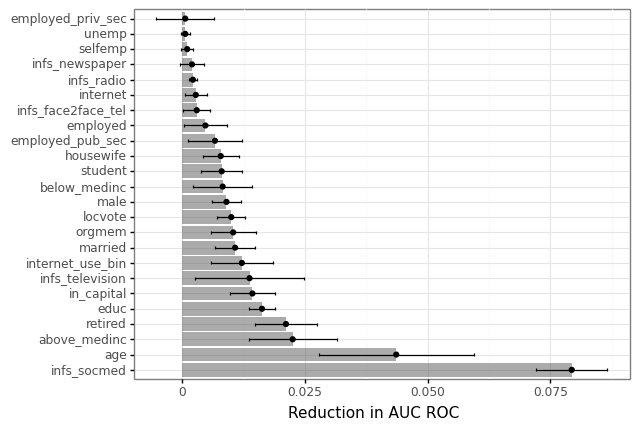

<ggplot: (8789852763700)>

In [40]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

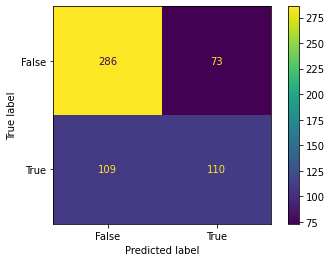

In [41]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(morocco)

In [42]:
score

0.7142591496000295

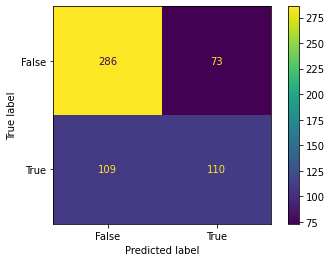

In [43]:
confusion.figure_

In [44]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1500))])

In [45]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [46]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,educ,0.054787,0.002392,0.050003,0.059570
1,age,0.025144,0.002408,0.020327,0.029961
2,internet_use_bin,0.016609,0.003780,0.009049,0.024169
3,male,0.012226,0.002927,0.006372,0.018080
4,infs_socmed,0.010957,0.004541,0.001875,0.020039
5,internet,0.010842,0.002318,0.006205,0.015479
6,orgmem,0.008881,0.001615,0.005652,0.012111
7,neighb_poor,0.007266,0.001916,0.003434,0.011099
8,neighb_mixed,0.005882,0.001118,0.003646,0.008119
9,locvote,0.005306,0.002044,0.001218,0.009393


In [47]:
vi_dat.to_csv("variable importance csv/morocco_y2")

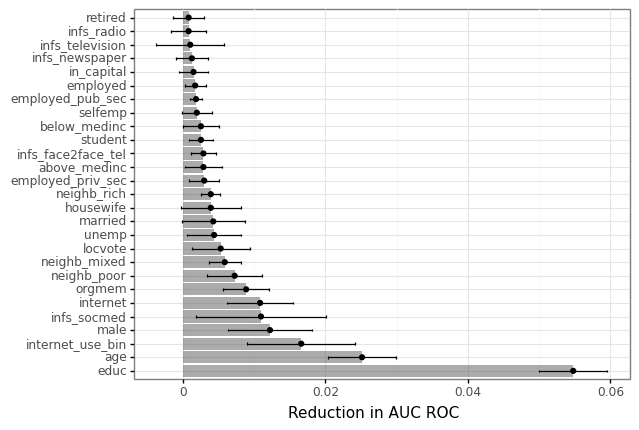

<ggplot: (8789822429365)>

In [48]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

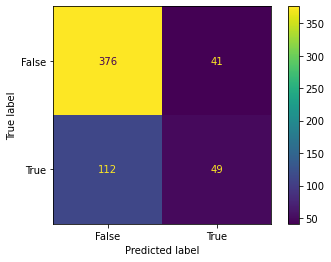

In [49]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(morocco)

In [50]:
score

0.7355319942680708

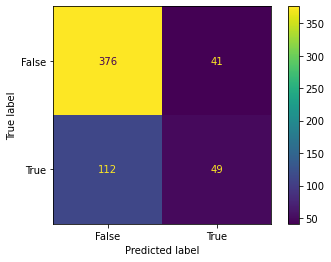

In [51]:
confusion.figure_

In [52]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=6, max_features=5,
                                        n_estimators=1000))])

In [53]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [54]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.052595,0.006216,0.040164,0.065026
1,locvote,0.051096,0.006282,0.038533,0.063659
2,infs_television,0.018339,0.006739,0.004861,0.031818
3,educ,0.016032,0.003429,0.009174,0.022891
4,neighb_poor,0.011880,0.001984,0.007911,0.015849
5,employed,0.010611,0.000937,0.008737,0.012485
6,married,0.008997,0.002792,0.003412,0.014581
7,infs_socmed,0.008535,0.002201,0.004134,0.012936
8,infs_face2face_tel,0.007497,0.001860,0.003778,0.011217
9,male,0.007151,0.002436,0.002279,0.012023


In [55]:
vi_dat.to_csv("variable importance csv/morocco_y1")

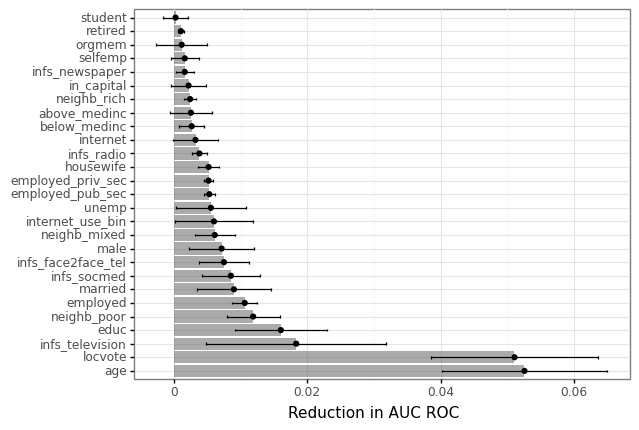

<ggplot: (8789751239560)>

In [56]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [57]:
egypt.drop(columns = "locvote", inplace = True)

In [58]:
egypt.dropna(inplace = True)

In [59]:
egypt.isna().sum()

below_medinc               0
above_medinc               0
in_capital                 0
married                    0
employed                   0
employed_pub_sec           0
employed_priv_sec          0
selfemp                    0
retired                    0
housewife                  0
student                    0
unemp                      0
neighb_rich                0
neighb_poor                0
neighb_mixed               0
educ                       0
male                       0
age                        0
orgmem                     0
internet                   0
internet_use_bin           0
infs_face2face_tel         0
infs_newspaper             0
infs_radio                 0
infs_television            0
infs_socmed                0
y_2_dem_pref_not_in_dem    0
y_1_trust_gov              0
dtype: int64

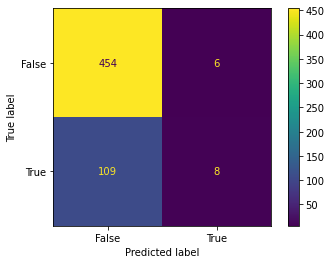

In [60]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(egypt)

In [61]:
score

0.7253016608960549

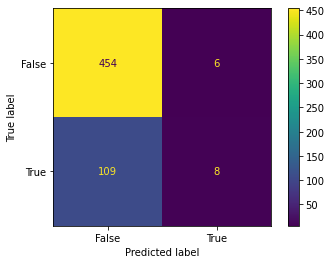

In [62]:
confusion.figure_

In [63]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, max_features=5,
                                        n_estimators=1000))])

In [64]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [65]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.032832,0.002175,2.848211e-02,0.037183
1,internet_use_bin,0.030867,0.003158,2.455191e-02,0.037182
2,infs_socmed,0.028092,0.002983,2.212555e-02,0.034059
3,educ,0.023353,0.002575,1.820322e-02,0.028502
4,orgmem,0.018613,0.001842,1.492777e-02,0.022298
5,infs_television,0.017457,0.002049,1.335953e-02,0.021554
6,below_medinc,0.017457,0.001691,1.407428e-02,0.020839
7,married,0.015029,0.002341,1.034718e-02,0.019711
8,employed,0.014220,0.001245,1.172940e-02,0.016710
9,internet,0.013873,0.002224,9.425345e-03,0.018320


In [66]:
vi_dat.to_csv("variable importance csv/egypt_y2")

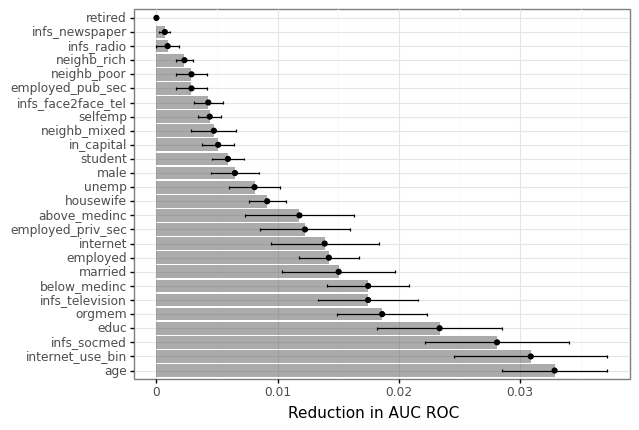

<ggplot: (8789835872434)>

In [67]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

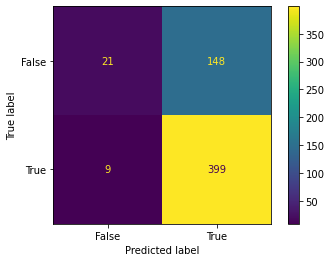

In [68]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = trustgov(egypt)

In [69]:
score

0.6541845082465022

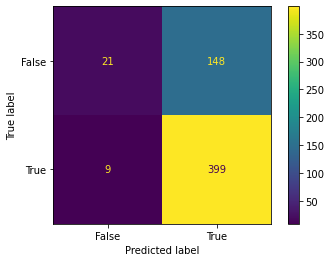

In [70]:
confusion.figure_

In [71]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, max_features=5,
                                        n_estimators=500))])

In [72]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [73]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.038266,0.001691,0.034884,0.041648
1,infs_television,0.022312,0.000694,0.020925,0.023699
2,internet_use_bin,0.020809,0.003290,0.014229,0.027390
3,unemp,0.017457,0.001610,0.014236,0.020677
4,married,0.015954,0.002087,0.011779,0.020128
5,infs_socmed,0.014451,0.001791,0.010869,0.018033
6,educ,0.013064,0.001190,0.010683,0.015444
7,male,0.011676,0.002352,0.006972,0.016381
8,internet,0.011445,0.003789,0.003868,0.019022
9,orgmem,0.010983,0.003102,0.004779,0.017187


In [74]:
vi_dat.to_csv("variable importance csv/egypt_y1")

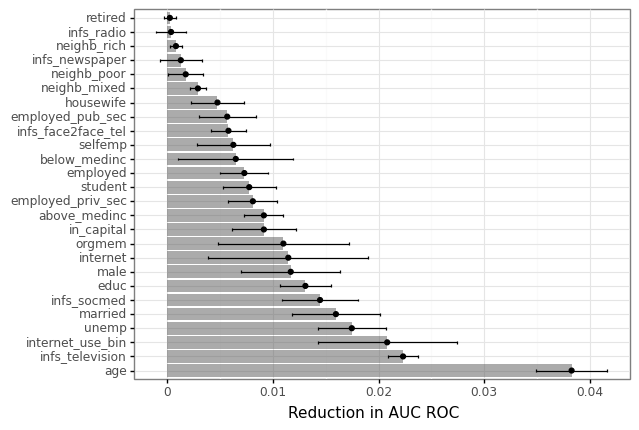

<ggplot: (8789822499819)>

In [75]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [76]:
algeria.dropna(inplace = True)

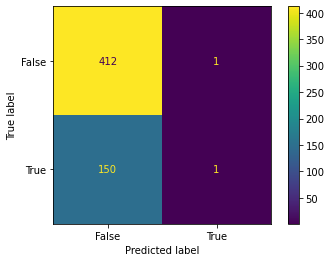

In [77]:
score, best_mod, pred_y, confusion, train_X, test_X, train_y, test_y = dempref(algeria)

In [78]:
score

0.6142446619177349

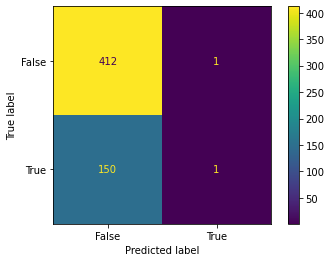

In [79]:
confusion.figure_

In [80]:
best_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=5,
                                        n_estimators=500))])

In [81]:
# permutation
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [82]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                        vi = vi['importances_mean'],
                        std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,age,0.009462,0.000836,0.007789,0.011134
1,internet_use_bin,0.008634,0.000802,0.007030,0.010238
2,educ,0.007215,0.002062,0.003090,0.011339
3,infs_newspaper,0.006505,0.000990,0.004526,0.008484
4,employed,0.006150,0.001159,0.003833,0.008468
5,male,0.006032,0.001263,0.003506,0.008558
6,neighb_poor,0.004258,0.001017,0.002223,0.006293
7,married,0.004140,0.000836,0.002467,0.005812
8,employed_pub_sec,0.004021,0.000690,0.002642,0.005401
9,above_medinc,0.003666,0.000690,0.002287,0.005046


In [83]:
vi_dat.to_csv("variable importance csv/algeria_y2")

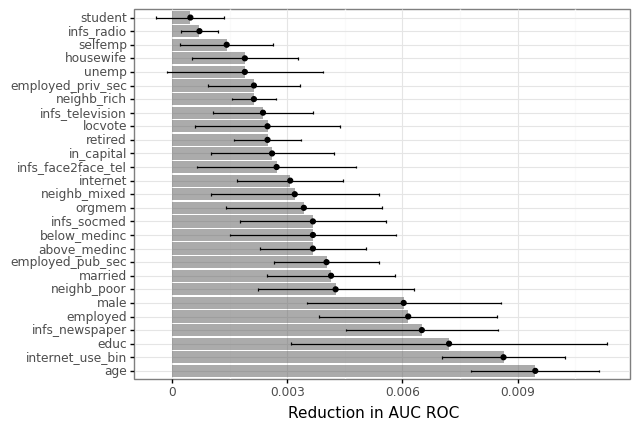

<ggplot: (8789822335416)>

In [84]:
# Plot
(
    ggplot(vi_dat,
        aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [85]:
from sklearn.datasets import make_classification

In [86]:
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = Logit(solver='lbfgs')
model.fit(trainX, trainy)

LogisticRegression()

In [87]:
# predict probabilities
yhat = model.predict_proba(testX)
yhat

array([[9.92758703e-01, 7.24129721e-03],
       [9.96495510e-01, 3.50448974e-03],
       [9.99867566e-01, 1.32433775e-04],
       ...,
       [9.98780592e-01, 1.21940764e-03],
       [9.99705540e-01, 2.94459735e-04],
       [9.99603387e-01, 3.96613003e-04]])

In [88]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [89]:
# keep probabilities for the positive outcome only
yhat

array([0.0072413 , 0.00350449, 0.00013243, ..., 0.00121941, 0.00029446,
       0.00039661])

In [90]:
# calculate roc curves
fpr, tpr, thresholds = m.roc_curve(testy, yhat)
print(fpr) 
print(tpr) 
print(thresholds)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.02020202e-04
 2.02020202e-04 6.06060606e-04 6.06060606e-04 1.01010101e-03
 1.01010101e-03 1.21212121e-03 1.21212121e-03 1.81818182e-03
 1.81818182e-03 3.63636364e-03 3.63636364e-03 5.65656566e-03
 5.65656566e-03 6.66666667e-03 6.66666667e-03 8.48484848e-03
 8.48484848e-03 1.01010101e-02 1.01010101e-02 1.37373737e-02
 1.37373737e-02 1.63636364e-02 1.63636364e-02 2.38383838e-02
 2.38383838e-02 4.28282828e-02 4.28282828e-02 4.56565657e-02
 4.56565657e-02 5.29292929e-02 5.29292929e-02 9.91919192e-02
 9.91919192e-02 1.57979798e-01 1.57979798e-01 2.35555556e-01
 2.35555556e-01 2.65252525e-01 2.65252525e-01 1.00000000e+00]
[0.   0.02 0.56 0.56 0.58 0.58 0.62 0.62 0.66 0.66 0.68 0.68 0.7  0.7
 0.72 0.72 0.74 0.74 0.76 0.76 0.78 0.78 0.8  0.8  0.82 0.82 0.84 0.84
 0.86 0.86 0.88 0.88 0.9  0.9  0.92 0.92 0.94 0.94 0.96 0.96 0.98 0.98
 1.   1.  ]
[1.99999835e+00 9.99998347e-01 4.96107783e-01 4.64133790e-01
 4.37378298e-01 4.10290652e-01 3.60605429e-

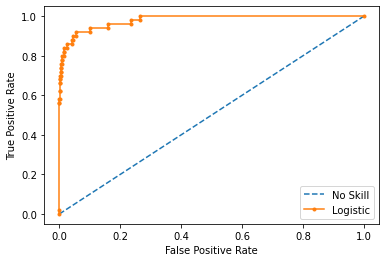

In [91]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

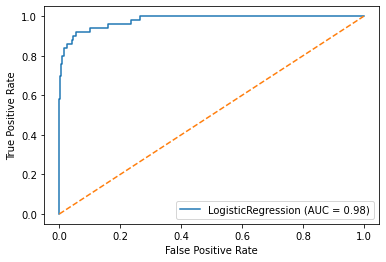

In [92]:
m.plot_roc_curve(model, testX, testy)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')